In [1]:
# imports
import html
import re
import string
from collections import Counter # like dict except returns 0 rather than key error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel

from data_loader import load_dataset

In [10]:
nlp = spacy.load('en_core_web_sm')

# global var
RAND_SEED = 42
STOPWORDS = nlp.Defaults.stop_words
PROTECTED_WORDS = {'isis', 'news', 'texas', 'paris', 'alps'} # words not to lemmatize
SAVE_DIR = './results/analytics/' # set to None to disable saving

# use regex to remove patterns
RE_PATTERNS = [
    re.compile(r'https?://\S+|www\.\S+'), # url
    re.compile(r'@\w+'), # mentions
    re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0" # <-- these are unicode ranges
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE),
]

# event-specific words to remove (not super informative for stance analysis)
TOPIC_WORDS = [
    'charlie', 'hebdo', 'charliehebdo',
    'ebola', 'essien',
    'ferguson',
    'germanwings',
    'ottawa', 'shooting',
    'prince', 'toronto',
    'putin', 'missing',
    'sydney', 'siege', 'sydneysiege',
]
# comment out to include topic words in analysis
RE_PATTERNS.append(re.compile(r'\b(' + '|'.join(TOPIC_WORDS) + r')\b'))

sns.set_theme(style='whitegrid')

In [3]:
def tokenize(text, lemmatize=True):
    text = text.lower()
    
    # decode HTML entities (&amp, etc.)
    text = html.unescape(text)
    
    # remove patterns w/ regex
    for pattern in RE_PATTERNS:
        text = pattern.sub(r'', text)
    
    # remove punct
    punct_table = str.maketrans('', '', string.punctuation)
    text = text.translate(punct_table)
    
    # tokenise, filter stopwords & lemmatise
    doc = nlp(text)
    if lemmatize:
        # protect certain words - otherwise lemmatise
        tokens = [
            t.text if t.text in PROTECTED_WORDS else t.lemma_
            for t in doc
            if t.text not in STOPWORDS and len(t.text) > 2 and not t.is_space
        ]
    else:
        # without lemmatisation for comparison
        tokens = [
            t.text for t in doc
            if t.text not in STOPWORDS and len(t.text) > 2 and not t.is_space
        ]
    
    return tokens

In [4]:
# load dataset
train_df, dev_df, test_df = load_dataset()
all_df = pd.concat([train_df, dev_df, test_df])

# class proportions
print("\nClass proportions in TRAIN set:")
print(train_df['label_text'].value_counts(normalize=True).mul(100))

print("\nClass proportions in DEV set:")
print(dev_df['label_text'].value_counts(normalize=True).mul(100))

print("\nClass proportions in TEST set:")
print(test_df['label_text'].value_counts(normalize=True).mul(100))

Loading cached data from saved_data/datasets.pkl...

Class proportions in TRAIN set:
label_text
comment    64.511562
support    19.844266
deny        7.857480
query       7.786692
Name: proportion, dtype: float64

Class proportions in DEV set:
label_text
comment    61.565836
support    24.555160
query       9.964413
deny        3.914591
Name: proportion, dtype: float64

Class proportions in TEST set:
label_text
comment    74.165872
query      10.104862
support     8.960915
deny        6.768351
Name: proportion, dtype: float64


In [5]:
# (a) unigrams and bigrams

# 1 - vars
reply_df = all_df[all_df['source_id'].notna()] # only plot replies
top_n = 10 # top n to plot

# 2 - get unigrams and bigrams
def get_bigrams(tokens):
    return [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]

unigrams = {'support': Counter(), 'deny': Counter(), 'query': Counter(), 'comment': Counter()}
bigrams = {'support': Counter(), 'deny': Counter(), 'query': Counter(), 'comment': Counter()}

for _, row in reply_df.iterrows():
    tokens = tokenize(row['text'])
    unigrams[row['label_text']].update(tokens)
    bigrams[row['label_text']].update(get_bigrams(tokens))

# 3 - print top unigrams and bigrams by stance
labels = ['support', 'deny', 'query', 'comment']

for label in labels:
    top_uni = unigrams[label].most_common(top_n)
    top_bi = bigrams[label].most_common(top_n)
    print(f"{label.upper()}")
    print(f"unigrams: {', '.join([w for w, _ in top_uni])}")
    print(f"bigrams:  {', '.join([' '.join(b) for b, _ in top_bi])}\n")


SUPPORT
unigrams: hostage, police, paris, break, kill, cafe, say, report, news, gunman
bigrams:  paris photo, supermarket paris, hostage free, free jewish, jewish supermarket, photo thomas, thomas samson, samson afp, french alps, airbus a320

DENY
unigrams: flag, say, know, like, report, lie, news, police, hostage, need
bigrams:  isis flag, need help, islamic flag, parliament hill, stop spread, hostage hold, hostage situation, shahada flag, ray hadley, mike brown

QUERY
unigrams: police, report, hostage, source, right, tell, know, think, kill, people
bigrams:  mike brown, escape cafe, look like, isis flag, hostage escape, police confirm, pay driver, michael brown, police chief, tomorrow night

COMMENT
unigrams: police, people, like, know, kill, hostage, think, say, shoot, need
bigrams:  parliament hill, look like, war memorial, fire parliament, sound like, stay safe, 2009 police, police beat, beat man, man charge



Saved: ./results/analytics/token_dist.png


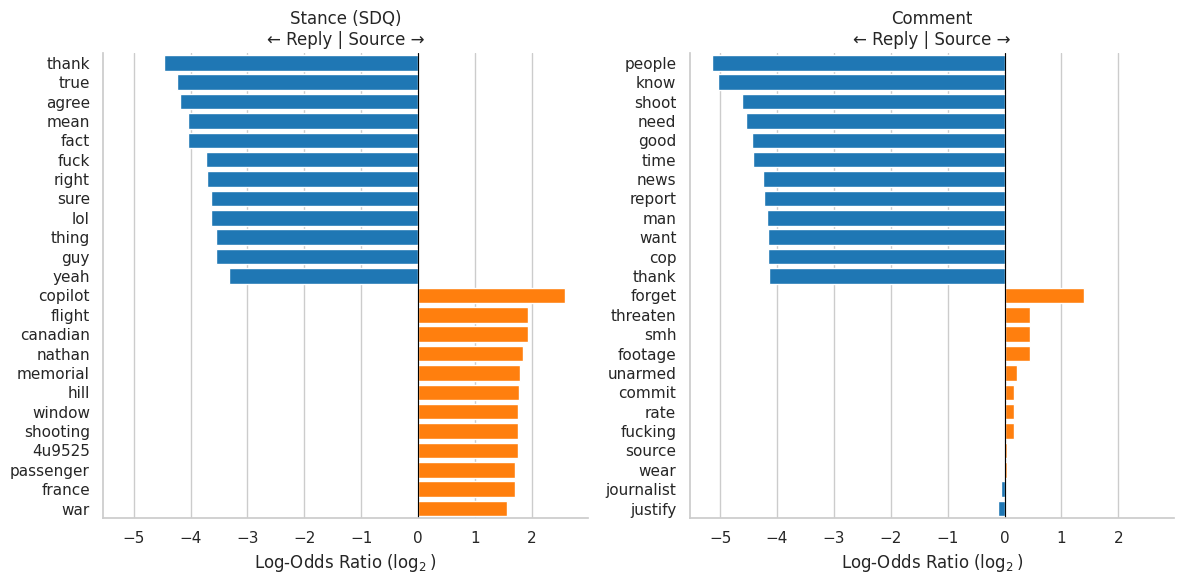

In [11]:
# (a) comparing token distributions

top_n = 12 # top n to plot
min_occurence = 10 # min count for words to include

def compute_log_odds_ratio(counter_a, counter_b, prior=0.5):
    # from stackoverflow - uses jeffreys prior smoothing
    all_words = set(counter_a.keys()) | set(counter_b.keys())
    total_a, total_b = sum(counter_a.values()), sum(counter_b.values())
    n = len(all_words)
    
    return {w: np.log2((counter_a.get(w, 0) + prior) / (total_a + prior * n) /
                       ((counter_b.get(w, 0) + prior) / (total_b + prior * n)))
            for w in all_words}

def get_top_log_odds_words(log_odds, counter_a, counter_b, n=top_n, min_count=min_occurence):
    filtered = {w: v for w, v in log_odds.items() 
                if counter_a.get(w, 0) + counter_b.get(w, 0) >= min_count}
    sorted_words = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[-n:][::-1] + sorted_words[:n] # reply on LHS, then source on rhs

# 1 - group tokens by source/reply and stance/comment
all_df = all_df.copy()
all_df['tokens'] = all_df['text'].apply(tokenize)
all_df['group'] = (all_df['source_id'].isna().map({True: 'source', False: 'reply'}) + '_' +
                   (all_df['label_text'] != 'comment').map({True: 'stance', False: 'comment'}))

counters = all_df.groupby('group')['tokens'].sum().apply(Counter).to_dict() # get dict of counter objects

# 2 - compute log-odds and get top words
comparisons = [
    ('source_stance', 'reply_stance', 'Stance (SDQ)'),
    ('source_comment', 'reply_comment', 'Comment')
]

plot_data = []
for src, rpl, panel in comparisons:
    log_odds = compute_log_odds_ratio(counters[src], counters[rpl])
    top_words = get_top_log_odds_words(log_odds, counters[src], counters[rpl])
    plot_data.extend({'word': w, 'log_odds': v, 'type': 'Source' if v > 0 else 'Reply', 'panel': panel}
                     for w, v in top_words)

plot_df = pd.DataFrame(plot_data)

# 3 - plot
g = sns.FacetGrid(plot_df, col='panel', sharex=True, sharey=False, height=6)
g.map_dataframe(sns.barplot, x='log_odds', y='word', hue='type', palette="tab10", saturation=1)

for ax in g.axes.flat:
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_xlabel(f'Log-Odds Ratio ({r"$\log_2$"})')
    ax.set_ylabel('')
    ax.set_title(f'{ax.get_title().replace("panel = ", "")}\n← Reply | Source →')
g.tight_layout()

if SAVE_DIR:
    g.savefig(SAVE_DIR + 'token_dist.png', dpi=150, bbox_inches='tight')
    print(f"Saved: {SAVE_DIR}token_dist.png")
plt.show()

In [7]:
# (b) LDA analysis

n_topics = 6 # seemed good from gensim cohesion model tried during testing

# run lda for each stance (use reply_df defined earlier to only plot replies)
stance_df = reply_df[reply_df['label_text'].isin(['support', 'deny', 'query'])]
comment_df = reply_df[reply_df['label_text'] == 'comment']

# tokenize
stance_texts = stance_df['text'].apply(tokenize).tolist()
comment_texts = comment_df['text'].apply(tokenize).tolist()

# build corpora and dicts
stance_id2word = corpora.Dictionary(stance_texts)
stance_corpus = [stance_id2word.doc2bow(text) for text in stance_texts]

comment_id2word = corpora.Dictionary(comment_texts)
comment_corpus = [comment_id2word.doc2bow(text) for text in comment_texts]

# train models
stance_lda = LdaModel(
    corpus=stance_corpus, id2word=stance_id2word, num_topics=n_topics,
    passes=20, random_state=RAND_SEED, alpha='auto', eta='auto'
)
comment_lda = LdaModel(
    corpus=comment_corpus, id2word=comment_id2word, num_topics=n_topics,
    passes=20, random_state=RAND_SEED, alpha='auto', eta='auto'
)

In [8]:
# topic word lists
n_words_to_show = 10

def get_topic_words(lda_model, n_words=20):
    topics = []
    for topic_id in range(lda_model.num_topics):
        top_terms = lda_model.get_topic_terms(topic_id, topn=n_words)
        top_words = [(lda_model.id2word[word_id], prob) for word_id, prob in top_terms]
        topics.append(top_words)
    return topics

def create_topic_table(lda_model, n_words=10):
    """Create a DataFrame of top words per topic for easy export."""
    topics = get_topic_words(lda_model, n_words)
    table_data = {f'Topic {i+1}': [word for word, _ in topic] for i, topic in enumerate(topics)}
    return pd.DataFrame(table_data)

stance_table = create_topic_table(stance_lda, n_words=n_words_to_show)
comment_table = create_topic_table(comment_lda, n_words=n_words_to_show)

print("Stance topics:")
print(stance_table)

print("\nComment topics:")
print(comment_table)

Stance topics:
   Topic 1  Topic 2    Topic 3  Topic 4 Topic 5      Topic 6
0    right     flag     police  hostage  report        paris
1   police  hostage    hostage     hold    news      hostage
2  suspect     isis        say    think   break       police
3     need     know       kill     look  attack         kill
4     kill  islamic       hour   people   video        break
5     know     news  situation     cafe  source        photo
6    shoot     take       cafe     like     lie  supermarket
7  confirm   report      black   report  happen         tell
8     look   gunman     people     mike    hear          afp
9     help   people       good     want   shoot       french

Comment topics:
   Topic 1 Topic 2  Topic 3     Topic 4   Topic 5  Topic 6
0     like    know   police  parliament       sad    thank
1     safe  people     want      police     right    break
2     look      go     kill      report      time    paris
3     hope     try      man        hill    happen     news
4 

Saved: ./results/analytics/stance_wordcloud.png


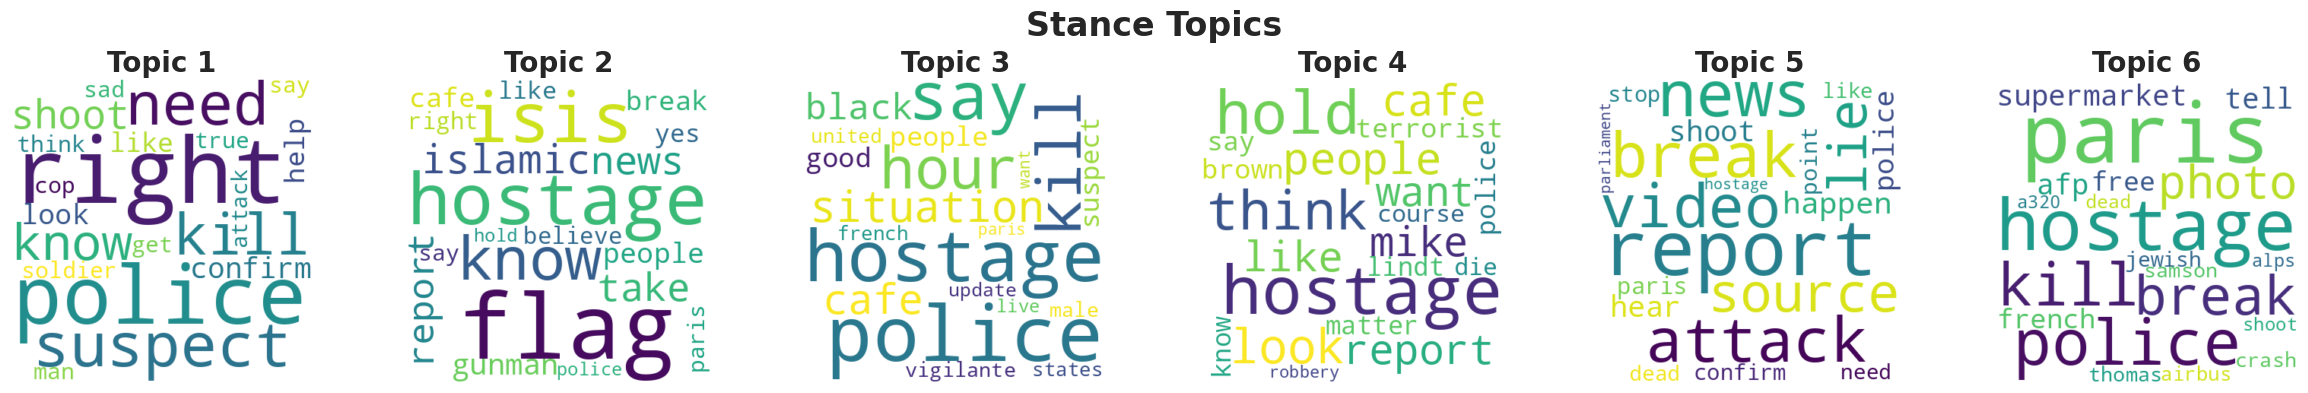

Saved: ./results/analytics/comment_wordcloud.png


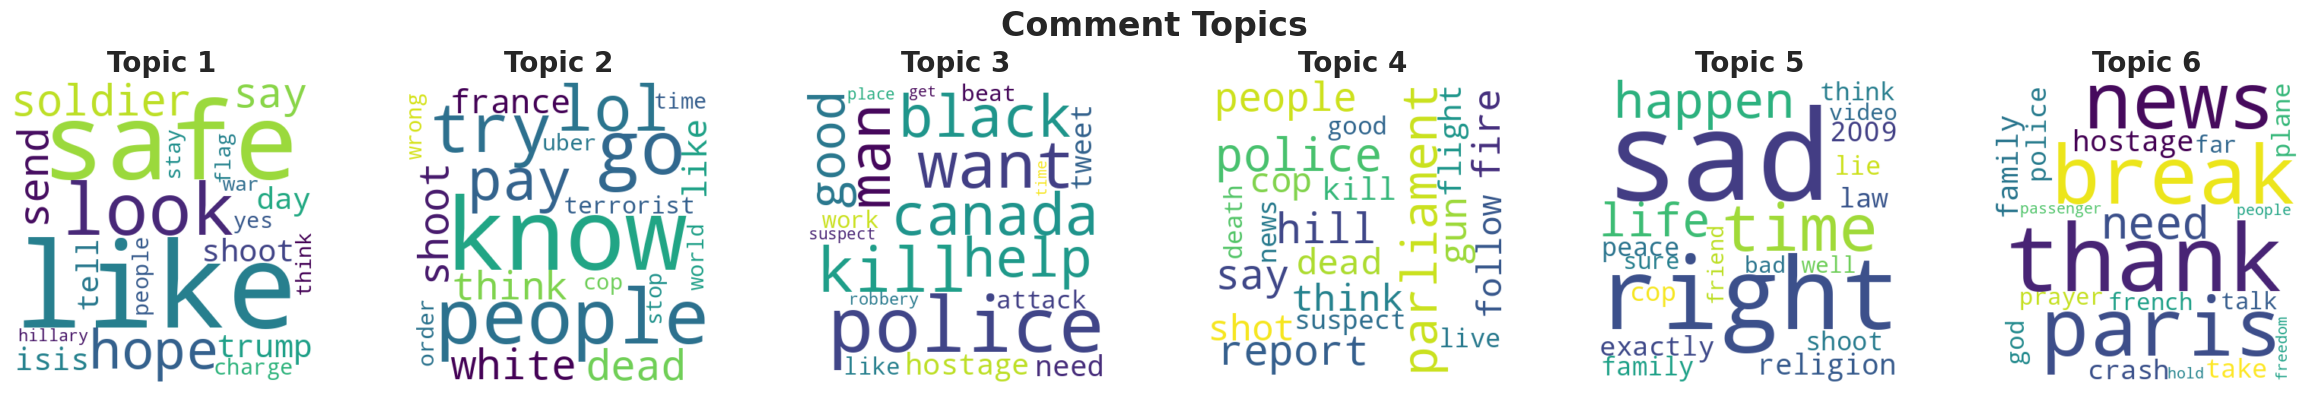

In [12]:
# wordclouds
n_words_to_show = 20

def create_wordcloud(topics, title, save_path=None):
    _, axes = plt.subplots(1, len(topics), figsize=(4*len(topics), 4))
    
    for i, (ax, topic) in enumerate(zip(np.atleast_1d(axes), topics)):
        word_freq = {word: score for word, score in topic}
        wc = WordCloud(width=400, height=400, background_color='white',
                       max_words=50, min_font_size=12)
        wc.generate_from_frequencies(word_freq)
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f'Topic {i+1}', fontsize=20, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle(title, fontsize=24, fontweight='bold')
    plt.tight_layout()
    
    if save_path: 
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()

stance_topics = get_topic_words(stance_lda, n_words_to_show)
save_path = SAVE_DIR + "stance_wordcloud.png" if SAVE_DIR else None
create_wordcloud(stance_topics, "Stance Topics", save_path)

comment_topics = get_topic_words(comment_lda, n_words_to_show)
save_path = SAVE_DIR + "comment_wordcloud.png" if SAVE_DIR else None
create_wordcloud(comment_topics, "Comment Topics", save_path)